In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
Inspector=inspect(engine)
columns=Inspector.get_columns('measurement')
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#raw data
data=session.query(Measurement.date, Measurement.prcp).statement
prcp_df=pd.read_sql_query(data,session.bind)
prcp_df=prcp_df.set_index("date")
prcp_df.head()

,prcp
date,
2010-01-01,0.08
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-06,NaN


In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

('2017-08-23',)
2016-08-23


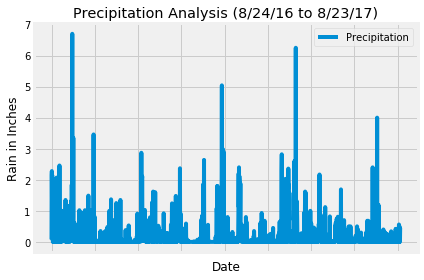

In [14]:
# Perform a query to retrieve the data and precipitation 
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
data_oneyear=session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > last_year).\
    order_by(Measurement.date).statement
prcp_oneyear=pd.read_sql_query(data_oneyear,session.bind)
prcp_oneyear=prcp_oneyear.set_index("date")
# drop NaN values
prcp_oneyear=prcp_oneyear.dropna()
prcp_oneyear.head()
#Use Pandas Plotting with Matplotlib to plot the data
prcp_oneyear.plot(title="Precipitation Analysis (8/24/16 to 8/23/17)")
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.savefig("Output/Precipitation Analysis.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_oneyear.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station=session.query(Measurement.station).group_by(Measurement.station).count()
station
print(f'there are {station} stations is the dataset')

there are 9 stations is the dataset


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
top_stations=session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
top_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active=session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), 
                                  func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

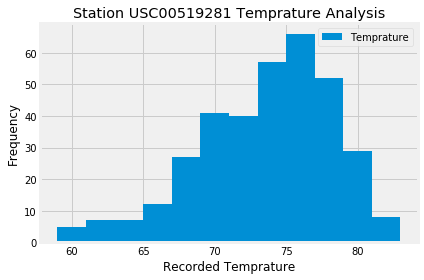

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data=session.query(Measurement.tobs).filter(Measurement.date > last_year).filter(Measurement.station == "USC00519281").all()

station_df=pd.DataFrame(station_data)

#Plot the data
station_df.plot.hist(bins=12,title="Station USC00519281 Temprature Analysis")
plt.xlabel("Recorded Temprature")
plt.ylabel("Frequency")
plt.legend(["Temprature"])
plt.tight_layout()
plt.savefig("Output/Station USC00519281 Temprature Analysis.png")
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip=calc_temps("2017-07-01","2017-07-10")
print(trip)

[(69.0, 78.15254237288136, 87.0)]


<function matplotlib.pyplot.show(*args, **kw)>

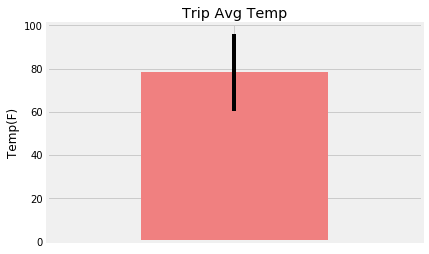

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df=pd.DataFrame(trip, columns=["TMIN","TAVE","TMAX"])
trip_df.plot.bar(y="TAVE",yerr=trip_df["TMAX"]-trip_df["TMIN"],color="lightcoral", title="Trip Avg Temp")
plt.gca().legend_.remove()
plt.ylabel("Temp(F)")
plt.tick_params(labelbottom=False)
plt.savefig("Output/Trip Avg Temp.png", bbox_inches="tight")
plt.show

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

items = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
trip_prcp = session.query(*items, func.sum(Measurement.prcp)).filter(Measurement.station==Station.station).\
    filter(Measurement.date >= "2017-07-01").filter(Measurement.date <= "2017-07-10").group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
trip_prcp

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.36),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.77),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.4),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.12),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.06),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.02),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]